In [1]:
import pandas as pd
from collections import deque
import random
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import time

from keras import layers
from keras import backend as K
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Dropout, Activation, LSTM, CuDNNLSTM, concatenate, Flatten, ConvLSTM2D,
                          BatchNormalization, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D)
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
from sklearn import preprocessing

from tools import SequenceFrame, plot_history

Using TensorFlow backend.


In [2]:
# temporal convolutional network
# https://github.com/philipperemy/keras-tcn
# https://arxiv.org/abs/1803.01271
# outperforms LSTM apparently.
try:
    from tcn import TCN
except ModuleNotFoundError:
    !pip install keras-tcn
    import tcn

In [3]:
SEQ_LEN = 128  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "LTC-USD"

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

# Preprocessing, train/test split

In [4]:
# load df
main_df = pd.read_csv('main_df.csv')
main_df.sort_values(by='time', ascending=True)
main_df = main_df.set_index('time')

In [5]:
# get input arrays for LSTM sequence training
sf = SequenceFrame(main_df,
                   forecast_vars=[f'{RATIO_TO_PREDICT}_close'],
                   reflection_vars=['.*'], # f'^((?!{RATIO_TO_PREDICT}).)*$'
                   forecast_steps=FUTURE_PERIOD_PREDICT,
                   reflection_steps=SEQ_LEN,
                   t0_past=True)

#print("using previous measurements:\n", sf.reflected_columns, "\n")
#print("to predict:\n", sf.forecasted_columns)

In [6]:
# get dfs of predictions and past sequence data, which will be reshaped
df_forecasted, df_reflected = sf.split_sequence_data()

# for parity, predict 3 timesteps in the future
df_forecasted = df_forecasted[[f'LTC-USD_close_t+{FUTURE_PERIOD_PREDICT}']]

# convert the future price values into higher (1) or lower (0) labels relative to most recent observed timestep
_df = pd.DataFrame()
target_columns = []
initial_columns = df_forecasted.columns

for c in initial_columns:
    target_columns.append(f'{c}_higher')
    _df[f'{c}_higher'] = (df_forecasted[c] > df_reflected[f'{RATIO_TO_PREDICT}_close_t']).astype(int) # 'current'
    df_forecasted = df_forecasted.join(_df)
else:
    df_forecasted.drop(initial_columns, axis=1, inplace=True)

In [7]:
# scale other prices to pct differences
for c in df_reflected.columns:
    df_reflected[c] = df_reflected[c].pct_change()
df_reflected.dropna(inplace=True)
for c in df_reflected.columns:
    df_reflected[c] = preprocessing.scale(df_reflected[c].values)
    
# get rid of first row of forecasts now
df_forecasted = df_forecasted.iloc[1:]

In [8]:
print(df_reflected.shape)
print(df_forecasted.shape)

(97592, 1024)
(97592, 1)


In [9]:
## here, split away some slice of the future data from the main dfs.
validation_frac = 0.2
split_ind = int((1-validation_frac)*len(df_reflected))

training_input = df_reflected[:split_ind].values
training_output = df_forecasted[:split_ind].values
validation_input = df_reflected[split_ind:].values
validation_output = df_forecasted[split_ind:].values

training_input = training_input.reshape((training_input.shape[0], SEQ_LEN, len(sf.reflection_vars)))
validation_input = validation_input.reshape((validation_input.shape[0], SEQ_LEN, len(sf.reflection_vars)))

In [10]:
print(training_input.shape, training_output.shape)
print(validation_input.shape, validation_output.shape)

(78073, 128, 8) (78073, 1)
(19519, 128, 8) (19519, 1)


### preprocessing sanity checks

In [11]:
# sanity check - first element of first input array is the set of 8 variables at the earliest timestep 
print(training_input[0,0])
print("")
print(df_reflected.iloc[0][:8])
print("")

# the output 0 implies price should go down
print(training_output[0])
print("")
print(main_df.iloc[SEQ_LEN]['LTC-USD_close'])
print(main_df.iloc[SEQ_LEN+FUTURE_PERIOD_PREDICT]['LTC-USD_close']) # confirm: should be lower FUTURE_PERIOD_PREDICT timesteps later

[-1.45379357 -0.08327015 -0.74487338 -0.00811448 -0.64558846 -0.00582764
 -0.01339682 -0.05338921]

BTC-USD_close_t-127    -1.453794
BTC-USD_volume_t-127   -0.083270
LTC-USD_close_t-127    -0.744873
LTC-USD_volume_t-127   -0.008114
BCH-USD_close_t-127    -0.645588
BCH-USD_volume_t-127   -0.005828
ETH-USD_close_t-127    -0.013397
ETH-USD_volume_t-127   -0.053389
Name: 1528976400, dtype: float64

[0]

97.970001
97.830002


In [12]:
# we want the same number of buys and sells, so we have to cut out some of our data according to which appears the least
# (first index is first axis - the number of samples)
buy_inds_train, sell_inds_train = np.where(training_output == [1])[0], np.where(training_output == [0])[0]
buy_inds_validation, sell_inds_validation = np.where(validation_output == [1])[0], np.where(validation_output == [0])[0]

# get the total numbers 
total_buys_train, total_buys_validation = len(buy_inds_train), len(buy_inds_validation)
total_sales_train, total_sales_validation = len(sell_inds_train), len(sell_inds_validation)

# the minimum in each dataset is the total number we use
n_use_train, n_use_validation = min(total_buys_train, total_sales_train), min(total_buys_validation, total_sales_validation)

print("buys, sales (training):")
print(total_buys_train, total_sales_train)
print("buys, sales (validation):")
print(total_buys_validation, total_sales_validation)

buys, sales (training):
32432 45641
buys, sales (validation):
8433 11086


In [13]:
# cut down our inputs to equalise buys and sells
training_input_lstm = np.concatenate(
    (training_input[buy_inds_train[:n_use_train]], training_input[sell_inds_train[:n_use_train]]))
training_output_lstm = np.concatenate(
    (training_output[buy_inds_train[:n_use_train]], training_output[sell_inds_train[:n_use_train]]))
validation_input_lstm = np.concatenate(
    (validation_input[buy_inds_validation[:n_use_validation]], validation_input[sell_inds_validation[:n_use_validation]]))
validation_output_lstm = np.concatenate(
    (validation_output[buy_inds_validation[:n_use_validation]], validation_output[sell_inds_validation[:n_use_validation]]))

### shuffle sequences

In [14]:
# shuffle inputs and outputs by same random permutation
trn_shuff_perm = np.random.permutation(training_input_lstm.shape[0])
val_shuff_perm = np.random.permutation(validation_input_lstm.shape[0])

# shuffle
training_input_lstm = training_input_lstm[trn_shuff_perm]
training_output_lstm = training_output_lstm[trn_shuff_perm]
validation_input_lstm = validation_input_lstm[val_shuff_perm]
validation_output_lstm = validation_output_lstm[val_shuff_perm]

# Setup Neural Networks

In [15]:
# board the CUDA train to seshlehem
try:
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    assert K.tensorflow_backend._get_available_gpus()
except:
    print("whoops, someone needs to buy a GPU...")
    print("make sure to go AFK for a while.")

## Network 1 - vanilla LSTM

In [16]:
def build_lstm_model(LSTM_nodes = 200,
                     dense_nodes = 50,
                     LSTM_layers = 3,
                     dense_layers = 1,
                     activation = 'relu',
                     dropout = 0.2,
                     input_dim=training_input_lstm.shape[-1],
                     reflection_steps=training_input_lstm.shape[1],
                     output_dim=training_output_lstm.shape[1],
                     regress=True):
    """ build LSTM model """

    model = Sequential()
    rs = True if LSTM_layers > 1 else False
    model.add(CuDNNLSTM(LSTM_nodes,
                        input_shape=(reflection_steps, input_dim),
                        return_sequences=rs))
    model.add(Dropout(dropout))
    for l in range(LSTM_layers-1):
        rs = False if l == LSTM_layers-2 else True
        model.add(CuDNNLSTM(LSTM_nodes, return_sequences=rs))
        model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation=activation))
    model.add(Dropout(dropout))
    for l in range(dense_layers-1):
        model.add(Dense(dense_nodes, activation=activation))
        model.add(Dropout(dropout))
    
    # connect to outputs if not using as part of a multi-input network
    if regress:
        model.add(Dense(1, activation='sigmoid'))#'softmax'))
    return model

In [17]:
# design network
# network hyperparameters
LSTM_nodes = 128
dense_nodes = 32
LSTM_layers = 3
dense_layers = 1
activation = 'relu'
dropout = 0.2

# training parameters
epochs = 100
batch_size = 50
validation_split = 0.2

# compile model
lstm_model = build_lstm_model(LSTM_nodes = LSTM_nodes,
                             dense_nodes = dense_nodes,
                             LSTM_layers = LSTM_layers,
                             dense_layers = dense_layers,
                             activation = activation,
                             dropout = dropout,
                             regress=True)

opt = keras.optimizers.Adam(lr=0.0005, decay=1e-6)

# Compile model
lstm_model.compile(
    loss='binary_crossentropy',#'sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

name = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-LSTM-{int(time.time())}"

tensorboard = TensorBoard(log_dir="logs/{}".format(name))
filepath = "LSTM-{epoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath,
                                                      monitor='val_acc',
                                                      verbose=1,
                                                      save_best_only=True,
                                                      mode='max')) # saves only the best ones
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)

## fit model

Train on 64864 samples, validate on 16866 samples
Epoch 1/100
64864/64864 [==============================] - 51s 788us/step - loss: 0.6913 - acc: 0.5193 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/100
64864/64864 [==============================] - 47s 730us/step - loss: 0.6921 - acc: 0.5074 - val_loss: 0.6963 - val_acc: 0.4967
Epoch 3/100
64864/64864 [==============================] - 48s 733us/step - loss: 0.6915 - acc: 0.5142 - val_loss: 0.6975 - val_acc: 0.4968
Epoch 4/100
64864/64864 [==============================] - 48s 738us/step - loss: 0.6914 - acc: 0.5146 - val_loss: 0.6975 - val_acc: 0.4969
Epoch 5/100
64864/64864 [==============================] - 48s 735us/step - loss: 0.6914 - acc: 0.5144 - val_loss: 0.6983 - val_acc: 0.4969
Epoch 6/100
64864/64864 [==============================] - 48s 735us/step - loss: 0.6913 - acc: 0.5144 - val_loss: 0.6975 - val_acc: 0.4968
Epoch 7/100
64864/64864 [==============================] - 48s 735us/step - loss: 0.6913 - acc: 0.5132 - val_l

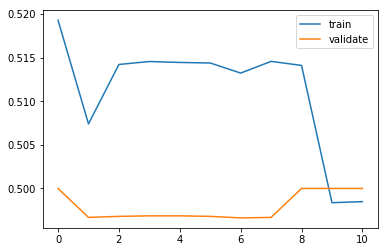

In [18]:
# fit network and plot loss
ltsm_history = lstm_model.fit(training_input_lstm, training_output_lstm,
                              epochs=epochs, batch_size=batch_size,
                              validation_data=(validation_input_lstm, validation_output_lstm),
                              verbose=1, shuffle=False, callbacks=[early_stop])

# plot history
plt.plot(ltsm_history.history['acc'], label='train')
plt.plot(ltsm_history.history['val_acc'], label='validate')
plt.legend()
plt.show()

# Network 2 - Encoder-decoder LSTM

In [19]:
# seq2seq: need to reshape training/testing output to 3d samples * timesteps * features form!
training_output_enc_dec_lstm = training_output_lstm.reshape(
    (training_output_lstm.shape[0], 1, training_output_lstm.shape[1]))
validation_output_enc_dec_lstm = validation_output_lstm.reshape(
    (validation_output_lstm.shape[0], 1, validation_output_lstm.shape[1]))

print(training_output_enc_dec_lstm.shape, training_output_lstm.shape)
print(validation_output_enc_dec_lstm.shape, validation_output_lstm.shape)

(64942, 1, 1) (64942, 1)
(16874, 1, 1) (16874, 1)


In [20]:
def build_enc_dec_lstm_model(LSTM_nodes = 100,
                             dense_nodes = 100,
                             encoder_LSTM_layers = 2,
                             decoder_LSTM_layers = 2,
                             dense_layers = 1,
                             activation = 'relu',
                             dropout = 0.2,
                             input_dim=training_input_lstm.shape[1:],
                             output_dim=training_output_enc_dec_lstm.shape[-1],
                             regress=True):
    """ build encoder-decoder LSTM model
        see:
            https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/
            
            https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time
            -series-forecasting-of-household-power-consumption/
    """
    model = keras.Sequential()

    ### encoder ------------------------------------------------------
    # learns relationship between steps in input sequence, develops internal representation of these
    # 1+ LSTM layers. Outputs fixed-size vector holding internal representation
    rs = True if encoder_LSTM_layers > 1 else False
    model.add(CuDNNLSTM(LSTM_nodes,
                        input_shape=input_dim,
                        return_sequences=rs))
    model.add(Dropout(dropout))
    for l in range(encoder_LSTM_layers-1):
        rs = False if l == encoder_LSTM_layers-2 else True # last layer doesn't return seq, just internal vector repr.
        model.add(CuDNNLSTM(LSTM_nodes, return_sequences=rs))
        model.add(Dropout(dropout))
    # internal representation of input sequence repeated multiple times,
    # once for each timestep in output sequence. this seq then presented to decoder
    # the decoder should map onto an output sequence
    # so we need 3D samples * timesteps (output seq) * (latent = n_lstm_nodes) features. 
    model.add(RepeatVector(training_output_enc_dec_lstm.shape[1])) # repeatvector fits encoder to decoder.

    ### decoder ------------------------------------------------------
    # converts internal representation into sequence output
    # 1+ LSTM layers outputting sequence, once for each forecasted timestep
    for l in range(decoder_LSTM_layers):
        model.add(CuDNNLSTM(LSTM_nodes, return_sequences=True))
        model.add(Dropout(dropout))
    
    ### output --------------------------------------------------------
    # decoder output here is shape: timesteps (output seq) * latent features (for timestep)
    # dense layer interprets each timestep in the output sequence one at a time
    # to do this use TimeDistributed wrapper, applying the same weights to each step
    model.add(TimeDistributed(Dense(dense_nodes, activation=activation)))
    model.add(Dropout(dropout))
    # output layer (softmax)
    # connect to outputs if not using as part of a multi-input network
    if regress:
        model.add(TimeDistributed(Dense(1, activation='sigmoid'))#'softmax')))

    return model

In [25]:
# design network
# network hyperparameters
LSTM_nodes = 128
dense_nodes = 32
encoder_LSTM_layers = 2
decoder_LSTM_layers = 2
dense_layers = 1
activation = 'relu'
dropout = 0.3
learning_rate=0.0001
# training parameters
epochs = 25
batch_size = 50

# build model
enc_dec_lstm_model = build_enc_dec_lstm_model(LSTM_nodes = LSTM_nodes,
                                              dense_nodes = dense_nodes,
                                              encoder_LSTM_layers = encoder_LSTM_layers,
                                              decoder_LSTM_layers = decoder_LSTM_layers,
                                              dense_layers = dense_layers,
                                              activation = activation,
                                              dropout = dropout,
                                              regress=True)

# define callback to force model to stop training if validation loss doesn't improve
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)
opt = keras.optimizers.Adam(lr=learning_rate, decay=1e-6)

# Compile model
enc_dec_lstm_model.compile(
    loss='binary_crossentropy',#'sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

Train on 64942 samples, validate on 16874 samples
Epoch 1/25
64942/64942 [==============================] - 24s 377us/step - loss: 0.6892 - acc: 0.4995 - val_loss: 0.7005 - val_acc: 0.5007
Epoch 2/25
64942/64942 [==============================] - 20s 302us/step - loss: 0.6686 - acc: 0.5020 - val_loss: 0.7082 - val_acc: 0.5003
Epoch 3/25
64942/64942 [==============================] - 20s 300us/step - loss: 0.6619 - acc: 0.5018 - val_loss: 0.7122 - val_acc: 0.4998
Epoch 4/25
64942/64942 [==============================] - 20s 304us/step - loss: 0.6597 - acc: 0.5013 - val_loss: 0.7135 - val_acc: 0.5005
Epoch 5/25
64942/64942 [==============================] - 20s 302us/step - loss: 0.6556 - acc: 0.5019 - val_loss: 0.7217 - val_acc: 0.5003
Epoch 6/25
64942/64942 [==============================] - 19s 300us/step - loss: 0.6536 - acc: 0.5021 - val_loss: 0.7096 - val_acc: 0.5005
Epoch 7/25
64942/64942 [==============================] - 20s 302us/step - loss: 0.6513 - acc: 0.5020 - val_loss: 0.

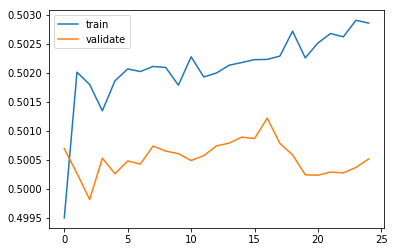

In [26]:
# fit network
enc_dec_ltsm_history = enc_dec_lstm_model.fit(training_input_lstm, training_output_enc_dec_lstm,
                              epochs=epochs, batch_size=batch_size,
                              validation_data=(validation_input_lstm, validation_output_enc_dec_lstm),
                              verbose=1, shuffle=False, callbacks=[early_stop]) # shuffle _sequences_, not steps

# plot history
plt.plot(enc_dec_ltsm_history.history['acc'], label='train')
plt.plot(enc_dec_ltsm_history.history['val_acc'], label='validate')
plt.legend()
plt.show()

## Network 3 - CNN-encoder LSTM-decoder network

In [21]:
# seq2seq: need to reshape training/testing output to 3d samples * timesteps * features form!
training_output_cnn_lstm = training_output_lstm.reshape(
    (training_output_lstm.shape[0], 1, training_output_lstm.shape[1]))
validation_output_cnn_lstm = validation_output_lstm.reshape(
    (validation_output_lstm.shape[0], 1, validation_output_lstm.shape[1]))

print(training_output_cnn_lstm.shape, training_output_lstm.shape)
print(validation_output_cnn_lstm.shape, validation_output_lstm.shape)

(64942, 1, 1) (64942, 1)
(16874, 1, 1) (16874, 1)


In [27]:
def build_cnn_lstm_model(training_inputs=training_input_lstm, # these are the same 3D format as lstm
                         training_outputs=training_output_cnn_lstm,
                         filters=64,
                         LSTM_nodes=200,
                         dense_nodes=100,
                         pool_size=2,
                         kernel_size=3,
                         activation='relu',
                         regress=True):

    n_timesteps_in, n_input_features = training_inputs.shape[1], training_inputs.shape[2]
    n_timesteps_out, n_output_features = training_outputs.shape[1], training_outputs.shape[2]
    # define model
    model = Sequential()
    # encoder ------------------------------------------
    # read in SEQ_LEN × 8 (input vars) 1D sequences. convolve w/ 64 size-3 (default) filters
    # to get new feature map of time series
    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation=activation,
                     input_shape=(n_timesteps_in, n_input_features)))
    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation=activation))
    # MaxPooling1D pools the interpretation into length-2 chunks, reducing output size
    model.add(MaxPooling1D(pool_size=pool_size))
    # Flatten ensures output reduced to 1D to feed into next layer 
    model.add(Flatten())
    # repeat internal representation of features to feed to LSTM decoder
    model.add(RepeatVector(n_timesteps_out))
    
    # decoder --------------------------------------------
    # SEE LSTM encoder-decoder
    model.add(LSTM(LSTM_nodes, activation=activation, return_sequences=True))
    
    # dense ---------------------------------------------
    model.add(TimeDistributed(Dense(dense_nodes, activation=activation)))
    
    # output ---------------------------------------------
    if regress:
        model.add(TimeDistributed(Dense(1, activation='sigmoid'))#'softmax'))) 
    return model

In [28]:
# design network
# network hyperparameters
filters = 64
dense_nodes = 32
LSTM_nodes = 200
encoder_LSTM_layers = 2
decoder_LSTM_layers = 2
dense_layers = 1
pool_size = 2
kernel_size = 3
activation = 'relu'
dropout = 0.3
learning_rate=0.0001
# training parameters
epochs = 25
batch_size = 50

# build model
cnn_lstm_model = build_cnn_lstm_model(training_inputs=training_input_lstm, # these are the same 3D format as lstm
                                      training_outputs=training_output_cnn_lstm,
                                      filters=filters,
                                      LSTM_nodes=LSTM_nodes,
                                      dense_nodes=dense_nodes,
                                      pool_size=pool_size,
                                      kernel_size=kernel_size,
                                      activation=activation)

# define callback to force model to stop training if validation loss doesn't improve
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)
opt = keras.optimizers.Adam(lr=learning_rate, decay=1e-6)

# Compile model
cnn_lstm_model.compile(
    loss='binary_crossentropy',#'sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [30]:
cnn_lstm_history = cnn_lstm_model.fit(training_input_lstm, training_output_cnn_lstm, epochs=epochs, batch_size=batch_size,
                                      validation_data=(validation_input_lstm, validation_output_cnn_lstm))

# plot history
plt.plot(cnn_lstm_history.history['acc'], label='train')
plt.plot(cnn_lstm_history.history['val_acc'], label='validate')
plt.legend()
plt.show()

Train on 64942 samples, validate on 16874 samples
Epoch 1/25
 6400/64942 [=>............................] - ETA: 10s - loss: 0.0856 - acc: 0.5106

KeyboardInterrupt: 

## Network 4 - ConvLSTM

ConvLSTM2D layers expect input:

    Samples: n, for the number of examples in the training dataset.
    Time: 10, for the ten subsequences that we split a window of 60 minutes into.
    Rows: 1, for the one-dimensional shape of each subsequence.
    Columns: 6, for the 6 minutes in each subsequence.
    Channels: 8, for the 8 features that we are working with as input.


In [52]:
# play 5-dimensional chess
n_subseq = 10 # 10 timesteps, composed of subsequences of 6 minutes
subseq_dim = 1

training_input_conv_lstm = training_input_lstm.reshape(
    (training_input_lstm.shape[0], n_subseq, subseq_dim, training_input_lstm.shape[1]//n_subseq, training_input_lstm.shape[2]))
validation_input_conv_lstm = validation_input_lstm.reshape(
    (validation_input_lstm.shape[0], n_subseq, subseq_dim, validation_input_lstm.shape[1]//n_subseq, validation_input_lstm.shape[2]))

print(training_input_conv_lstm.shape, training_input_lstm.shape)
print(validation_input_conv_lstm.shape, validation_input_lstm.shape)

(64942, 10, 1, 6, 8) (64942, 60, 8)
(16874, 10, 1, 6, 8) (16874, 60, 8)


In [53]:
# seq2seq: need to reshape training/testing output to 3d samples * timesteps * features form!
training_output_conv_lstm = training_output_lstm.reshape(
    (training_output_lstm.shape[0], 1, training_output_lstm.shape[1]))
validation_output_conv_lstm = validation_output_lstm.reshape(
    (validation_output_lstm.shape[0], 1, validation_output_lstm.shape[1]))

print(training_output_conv_lstm.shape, training_output_lstm.shape)
print(validation_output_conv_lstm.shape, validation_output_lstm.shape)

(64942, 1, 1) (64942, 1)
(16874, 1, 1) (16874, 1)


In [50]:
def build_conv_lstm_model(training_inputs=training_input_conv_lstm, # these are the same 3D format as lstm
                          training_outputs=training_output_conv_lstm,
                          filters=64,
                          LSTM_nodes=200,
                          dense_nodes=100,
                          pool_size=2,
                          kernel_size=3,
                          activation='relu',
                          regress=True):

    n_timesteps_in, n_rows_in, n_cols_in, n_input_features = training_inputs.shape[1:]
    n_timesteps_out, n_output_features = training_outputs.shape[1:]
    # define model
    model = Sequential()
    # encoder ------------------------------------------
    # read in SEQ_LEN × 8 (input vars) 1D sequences. convolve w/ 64 size-3 (default) filters
    # to get new feature map of time series
    model.add(ConvLSTM2D(filters=filters,
                         kernel_size=(1,kernel_size),
                         activation=activation,
                         input_shape=(n_timesteps_in, n_rows_in, n_cols_in, n_input_features)))
    # MaxPooling1D pools the interpretation into length-2 chunks, reducing output size
    #model.add(MaxPooling1D(pool_size=pool_size))
    # Flatten ensures output reduced to 1D to feed into next layer 
    model.add(Flatten())
    # repeat internal representation of features to feed to LSTM decoder
    model.add(RepeatVector(n_timesteps_out))
    
    # decoder --------------------------------------------
    # SEE LSTM encoder-decoder
    model.add(LSTM(LSTM_nodes, activation=activation, return_sequences=True))
    
    # dense ---------------------------------------------
    model.add(TimeDistributed(Dense(dense_nodes, activation=activation)))
    
    # output ---------------------------------------------
    if regress:
        model.add(TimeDistributed(Dense(1, activation='sigmoid'))#'softmax'))) 
    return model

In [55]:
# design network
# network hyperparameters
filters = 64
dense_nodes = 32
LSTM_nodes = 200
dense_layers = 1
pool_size = 2
kernel_size = 3
activation = 'relu'
dropout = 0.3
learning_rate=0.0001
# training parameters
epochs = 25
batch_size = 50

# build model
conv_lstm_model = build_conv_lstm_model(training_inputs=training_input_conv_lstm, # these are the same 3D format as lstm
                                        training_outputs=training_output_conv_lstm,
                                        filters=filters,
                                        LSTM_nodes=LSTM_nodes,
                                        dense_nodes=dense_nodes,
                                        pool_size=pool_size,
                                        kernel_size=kernel_size,
                                        activation=activation)

# define callback to force model to stop training if validation loss doesn't improve
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)
opt = keras.optimizers.Adam(lr=learning_rate, decay=1e-6)

# Compile model
conv_lstm_model.compile(
    loss='binary_crossentropy',#'sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [58]:
conv_lstm_history = conv_lstm_model.fit(training_input_conv_lstm, training_output_conv_lstm, epochs=epochs, batch_size=batch_size,
                                        validation_data=(validation_input_conv_lstm, validation_output_conv_lstm))

# plot history
plt.plot(conv_lstm_history.history['acc'], label='train')
plt.plot(conv_lstm_history.history['val_acc'], label='validate')
plt.legend()
plt.show()

Train on 64942 samples, validate on 16874 samples
Epoch 1/25
64942/64942 [==============================] - 34s 518us/step - loss: 0.6907 - acc: 0.5021 - val_loss: 0.7080 - val_acc: 0.4998
Epoch 2/25
64942/64942 [==============================] - 24s 375us/step - loss: 0.6762 - acc: 0.5002 - val_loss: 0.7516 - val_acc: 0.5006
Epoch 3/25
64942/64942 [==============================] - 24s 373us/step - loss: 0.6636 - acc: 0.5013 - val_loss: 0.7572 - val_acc: 0.5006
Epoch 4/25
64942/64942 [==============================] - 25s 388us/step - loss: 0.6578 - acc: 0.5017 - val_loss: 0.7589 - val_acc: 0.5011
Epoch 5/25
64942/64942 [==============================] - 26s 404us/step - loss: 0.6542 - acc: 0.5014 - val_loss: 0.7919 - val_acc: 0.5014
Epoch 6/25
64942/64942 [==============================] - 26s 402us/step - loss: 0.6503 - acc: 0.5014 - val_loss: 0.7599 - val_acc: 0.5012
Epoch 7/25
64942/64942 [==============================] - 26s 400us/step - loss: 0.6475 - acc: 0.5020 - val_loss: 0.

KeyboardInterrupt: 

# Network 5 - TCN

In [ ]:
# Receptive field = nb_stacks_of_residuals_blocks * kernel_size * last_dilation

In [6]:
# LONG_SEQ_LEN = 600
# TODO: add deque/pure np array version of 3d reshaping that's less memory intensive to take advantage of longer sequences 

In [20]:
def build_TCN_model(training_inputs=training_input_lstm, # these are the same 3D format as lstm
                    training_outputs=training_output_lstm,
                    filters=64,
                    kernel_size=2,
                    dilations=[1,2,4,8,16,32],
                    stacks=2,
                    padding='causal',
                    dropout=0.0,
                    TCN_nodes=200,
                    dense_nodes=100,
                    activation='relu',
                    regress=True):

    n_timesteps_in, n_input_features = training_inputs.shape[1:]
    n_output_features = training_outputs.shape[1]
    # define model
    i = Input(shape=(n_timesteps_in, n_input_features))   
    x = TCN(nb_filters=filters,
            kernel_size=kernel_size,
            nb_stacks=stacks,
            dilations=dilations,
            padding=padding,
            use_skip_connections=True,
            dropout_rate=dropout,
            return_sequences=True)(i)
    x = TCN(nb_filters=filters,
            kernel_size=kernel_size,
            nb_stacks=stacks,
            dilations=dilations,
            padding=padding,
            use_skip_connections=True,
            dropout_rate=dropout,
            return_sequences=False)(x)   
    
    # output ---------------------------------------------
    if regress:
        o = Dense(1, activation='sigmoid')(x)#'softmax'))) 
    else:
        o = x
    return Model(inputs=[i], outputs=[o])

In [34]:
# design network
# network hyperparameters
filters=64
kernel_size=2
dilations=[1,2,4,8,16,32]
stacks=2
padding='causal'
dropout=0.3
TCN_nodes=200
dense_nodes=100
activation='relu'

# training parameters
learning_rate=0.0001
epochs = 100
batch_size = 30

# build model
tcn_model = build_TCN_model(training_inputs=training_input_lstm, # these are the same 3D format as lstm
                            training_outputs=training_output_lstm,
                            filters=filters,
                            kernel_size=kernel_size,
                            dilations=dilations,
                            stacks=stacks,
                            padding=padding,
                            dropout=dropout,
                            TCN_nodes=TCN_nodes,
                            dense_nodes=dense_nodes,
                            activation='relu',
                            regress=True)

# define callback to force model to stop training if validation loss doesn't improve
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)
opt = keras.optimizers.Adam(lr=learning_rate, decay=1e-6)

# Compile model
tcn_model.compile(
    loss='binary_crossentropy',#'sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

Train on 64864 samples, validate on 16866 samples
Epoch 1/100
64864/64864 [==============================] - 179s 3ms/step - loss: 1.9356 - acc: 0.5017 - val_loss: 0.7125 - val_acc: 0.5039
Epoch 2/100
64864/64864 [==============================] - 168s 3ms/step - loss: 0.7949 - acc: 0.4954 - val_loss: 0.7002 - val_acc: 0.5015
Epoch 3/100
64864/64864 [==============================] - 169s 3ms/step - loss: 0.7382 - acc: 0.4998 - val_loss: 0.6971 - val_acc: 0.5025
Epoch 4/100
64864/64864 [==============================] - 163s 3ms/step - loss: 0.7143 - acc: 0.4984 - val_loss: 0.7009 - val_acc: 0.5002
Epoch 5/100
64864/64864 [==============================] - 167s 3ms/step - loss: 0.7086 - acc: 0.5012 - val_loss: 0.6982 - val_acc: 0.4995
Epoch 6/100
64864/64864 [==============================] - 169s 3ms/step - loss: 0.7030 - acc: 0.5049 - val_loss: 0.6951 - val_acc: 0.5071
Epoch 7/100
64864/64864 [==============================] - 168s 3ms/step - loss: 0.7005 - acc: 0.5068 - val_loss: 0.

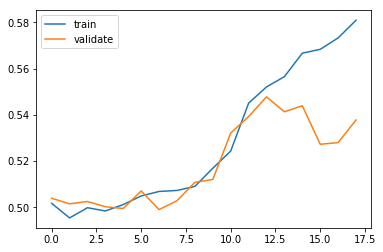

In [35]:
tcn_history = tcn_model.fit(training_input_lstm, training_output_lstm, epochs=epochs, batch_size=batch_size,
                            validation_data=(validation_input_lstm, validation_output_lstm), callbacks=[early_stop], shuffle=True)

# plot history
plt.plot(tcn_history.history['acc'], label='train')
plt.plot(tcn_history.history['val_acc'], label='validate')
plt.legend()
plt.show()

# Sequence-to-sequence w/ multivariate output